# Exploratory Data Analysis

In this step, we will perform data annotation, quality control, and normalization. Once the data is ready for analysis, we will perform cluster analysis to identify unique macrophage populations and differential expression analysis to find the up- and down-regulated expression genes in each cluster.

Since we only focus on studying the alteration macrophage spots within lung tissue, we will remove the upper airway spots of Vaped Female lung to mitigate potential bias related to lung tissue types.

In [38]:
import anndata as ad
import numpy as np

In [74]:
# Custom Plotting functions
import plot_st
import importlib
importlib.reload(plot_st)

<module 'plot_st' from '/Users/anhnguyen/Documents/My_Projects/ST_Data_Analysis/plot_st.py'>

In [40]:
root_dir = '/Users/anhnguyen/Documents/My_Projects/ST_Data_Analysis/'

In [41]:
# Read the data

adata_dir = root_dir + 'Raw_Initial_Data/'
adata_M24 = ad.read_h5ad(adata_dir + 'raw_M24.h5ad')
adata_F31 = ad.read_h5ad(adata_dir + 'raw_F31.h5ad')
adata_M63 = ad.read_h5ad(adata_dir + 'raw_M63.h5ad')
adata_F62 = ad.read_h5ad(adata_dir + 'raw_F62.h5ad')

In [42]:
# Guestimate the line which separate the upper airway and lung tissues.
def line(x):
  return -0.6 * x + 6900

In [43]:
distance = adata_F31.obsm['spatial'][:,1] - line(adata_F31.obsm['spatial'][:,0])
adata_F31 = adata_F31[distance < 0]
adata_F31.write_h5ad(adata_dir + 'no_airway_F31.h5ad')

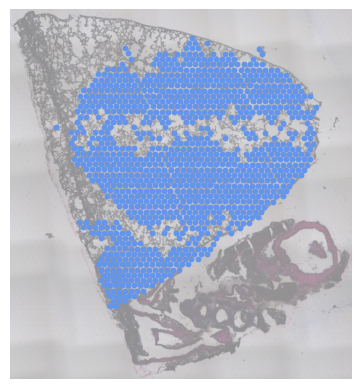

In [44]:
plot_st.spatial(adata_F31)

## Macrophage Identification

The identification of spots containing macrophage cells is identified based on
the level expression of macrophage biomarkers such as *Cd14* , *Cd68*, or
*Adgre1*. We will build a function to annotate macrophage spots and plot them as green spot, where non-macrophage spots are in cornflowerblue.

We will also save the macrophage spots to a new data containers.

In [45]:
def create_macrophage_adata (adata):
    macrophage_markers = ['Cd14', 'Cd68', 'Adgre1']
    mask1 = np.isin(adata.var_names, macrophage_markers)
    total_counts = np.array(adata.X[:, mask1].sum(axis=1))
    mask = (total_counts > 0)

    macrophage_adata = ad.AnnData(adata[mask].X)
    macrophage_adata.obs_names = adata[mask].obs_names
    macrophage_adata.var_names = adata[mask].var_names
    macrophage_adata.obsm['spatial'] = adata[mask].obsm['spatial']
    macrophage_adata.uns['extent'] = adata.uns['extent']
    macrophage_adata.uns['lung_image'] = adata.uns['lung_image']

    return macrophage_adata

In [46]:
macrophage_dir = 'results/macrophage_data/'

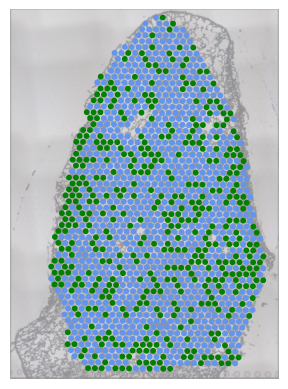

In [47]:
macrophage_M24 = create_macrophage_adata(adata_M24)
macrophage_M24.write_h5ad(root_dir + macrophage_dir + 'macrophage_M24.h5ad')
plot_st.spatial_macrophage(adata_M24)

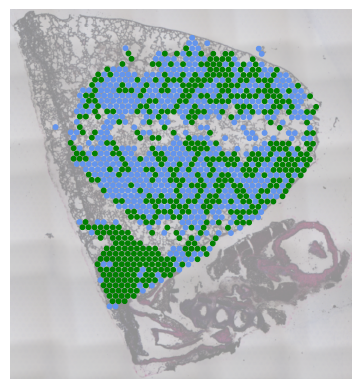

In [48]:
macrophage_F31 = create_macrophage_adata(adata_F31)
macrophage_F31.write_h5ad(root_dir + macrophage_dir + 'macrophage_F31.h5ad')
plot_st.spatial_macrophage(adata_F31)

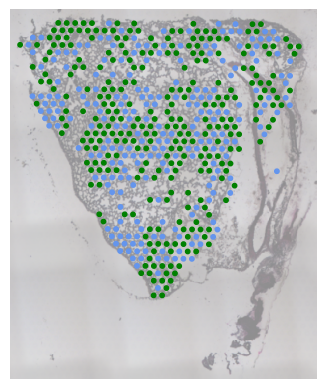

In [49]:
macrophage_M63 = create_macrophage_adata(adata_M63)
macrophage_M63.write_h5ad(root_dir + macrophage_dir + 'macrophage_M63.h5ad')
plot_st.spatial_macrophage(adata_M63)

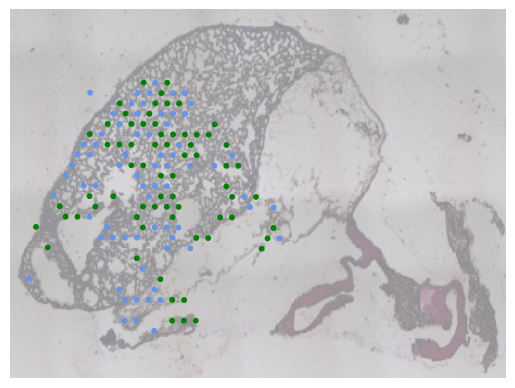

In [50]:
macrophage_F62 = create_macrophage_adata(adata_F62)
macrophage_F62.write_h5ad(root_dir + macrophage_dir + 'macrophage_F62.h5ad')
plot_st.spatial_macrophage(adata_F62)

In [51]:
macrophage_M24 = ad.read_h5ad(root_dir + macrophage_dir + 'macrophage_M24.h5ad')
macrophage_F31 = ad.read_h5ad(root_dir + macrophage_dir + 'macrophage_F31.h5ad')
macrophage_M63 = ad.read_h5ad(root_dir + macrophage_dir + 'macrophage_M63.h5ad')
macrophage_F62 = ad.read_h5ad(root_dir + macrophage_dir + 'macrophage_F62.h5ad')

## Quality Control

For Quality Control (QC), we will utilize [**Scanpy**](https://scanpy.readthedocs.io/en/stable/) package.

We will plot some basic QC plots to understand the distribution of total counts, gene counts, and percentage of mitochondrial.

* Spots that contained a total number of gene counts outside the 95th percentile for all spots were removed from the analysis.
* Spots that were identified to contain more than 20 percent of mitochondrial genes were removed from analysis to remove poor-quality spots.


In [52]:
import scanpy as sc

The ```preprocessing``` function calculates the total expression, gene counts, and percentage in mitochondrial in each spot. Those metrics are saved in the data container. The function also plots some of the basic QC plots such as the distribution of level of expressions and number of gene counts.

The function remove the spots with the level of expressions higher than 95% and percentage in mitochondrial higher than 20%.

In [53]:
def preprocessing (adata):
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

    plot_st.total_plot(adata)
    plot_st.gene_count_plot(adata)
    plot_st.QC_plot(adata)
    sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

    upper_lim_counts = np.quantile(adata.obs.total_counts.values, 0.95) # 95% percentile to be more objective
    adata = adata[adata.obs['total_counts'] < upper_lim_counts]

    adata = adata[adata.obs['pct_counts_mt'] < 20]

    return adata

Epoch 1/400:   0%|          | 0/400 [05:44<?, ?it/s]


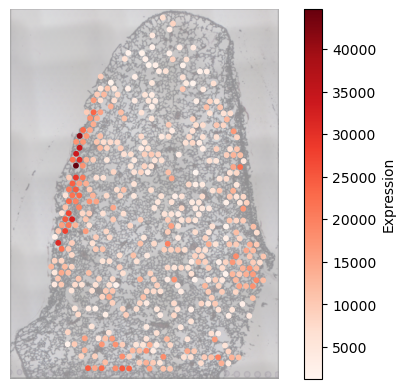

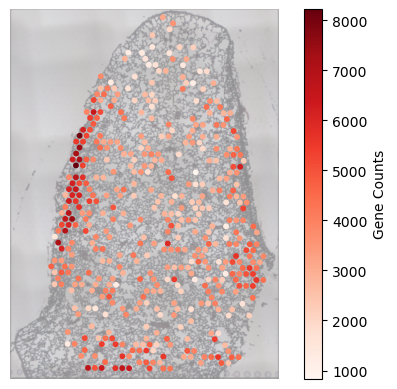

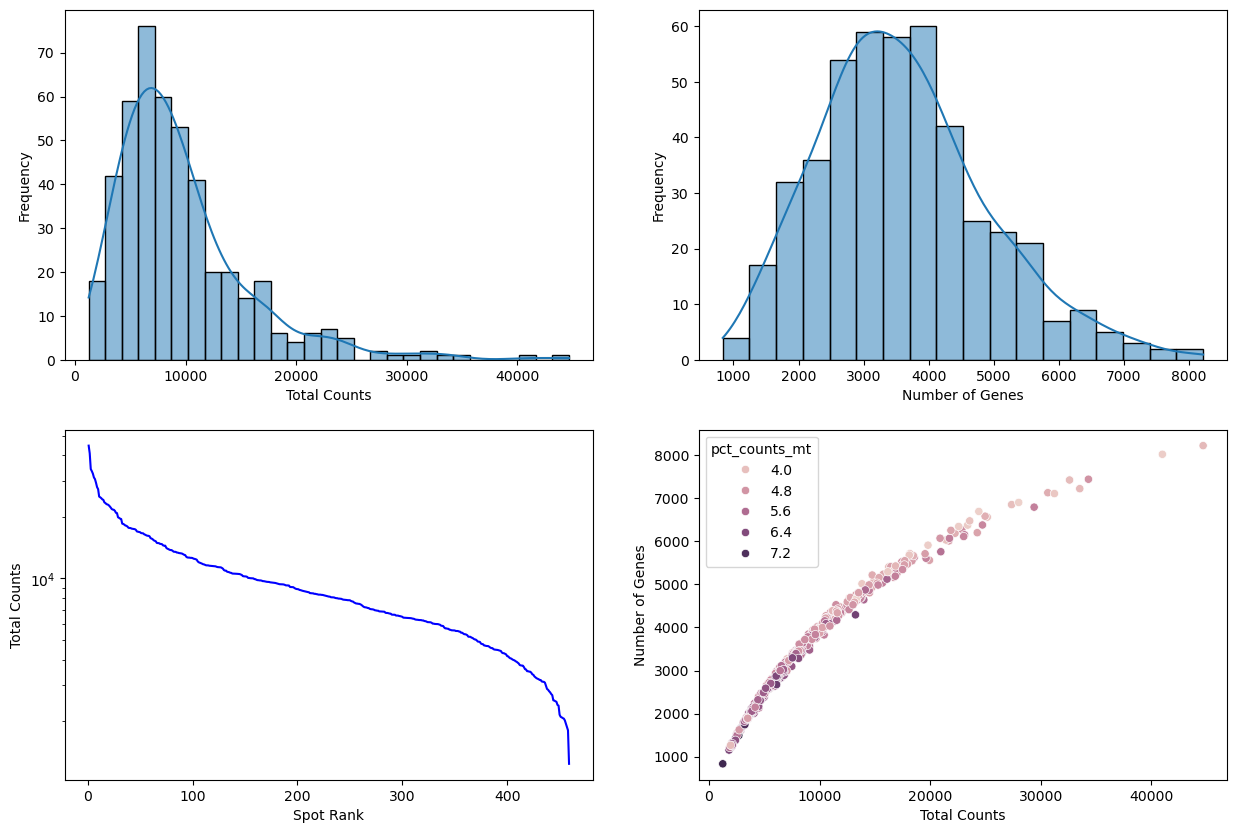

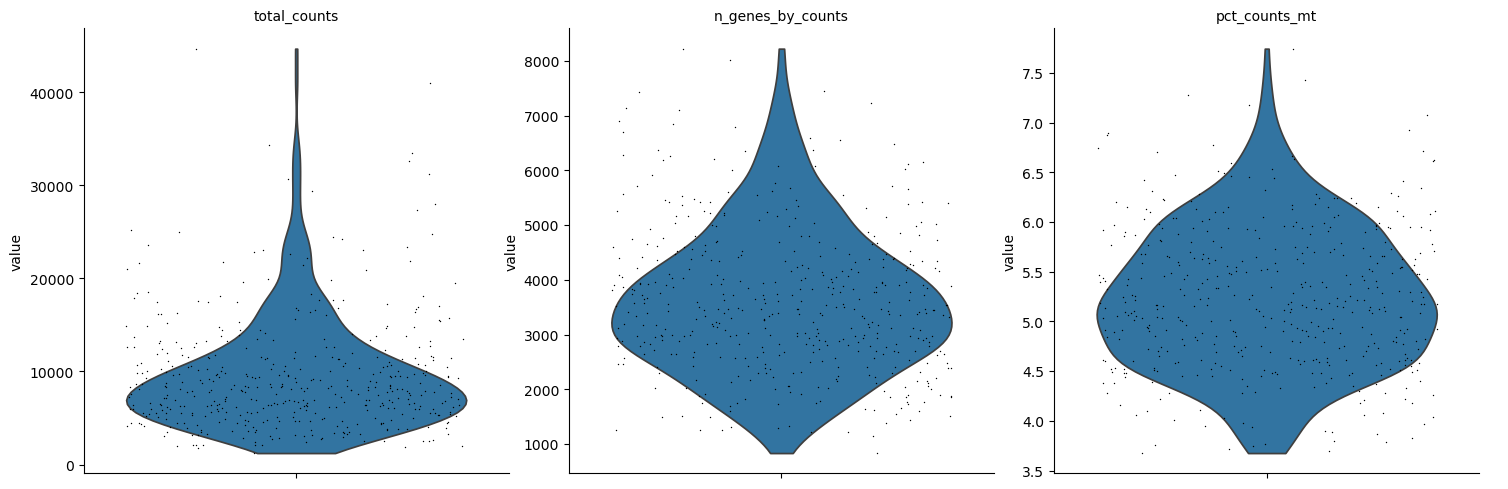

In [54]:
macrophage_M24 = preprocessing(macrophage_M24)

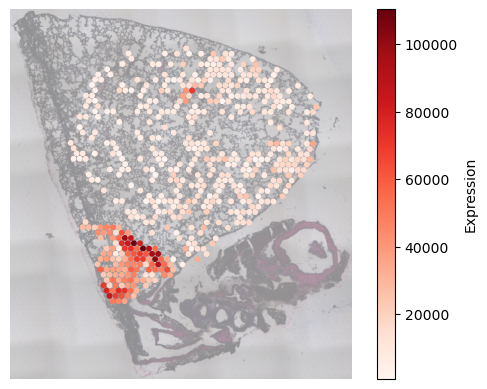

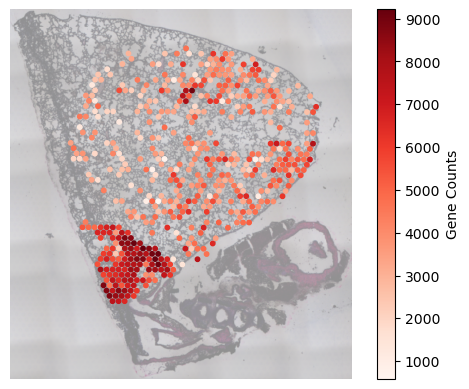

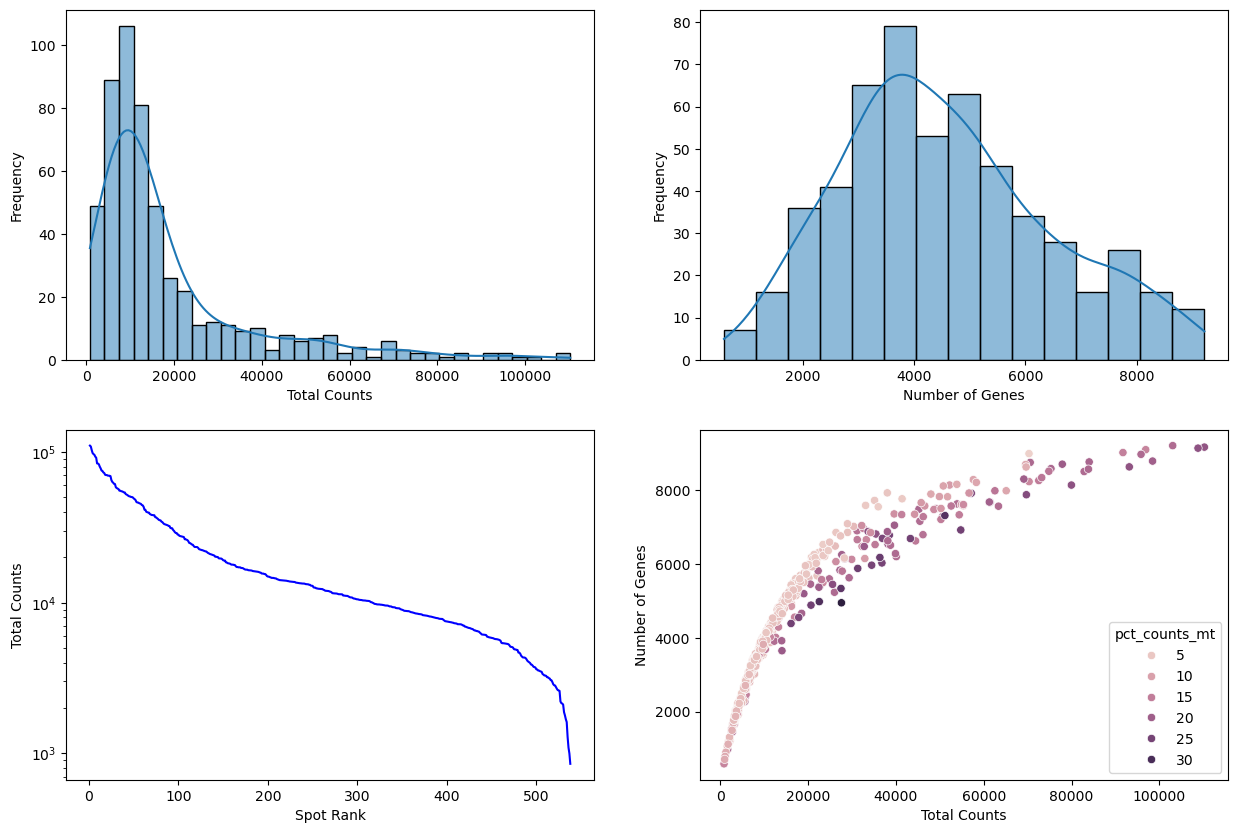

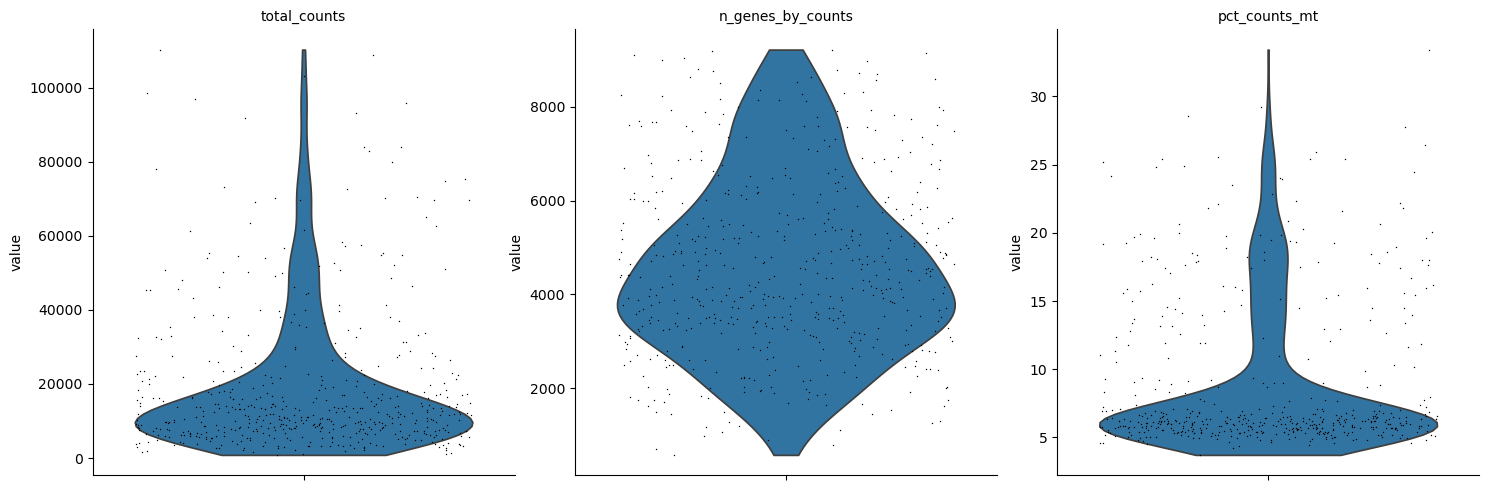

In [55]:
macrophage_F31 = preprocessing(macrophage_F31)

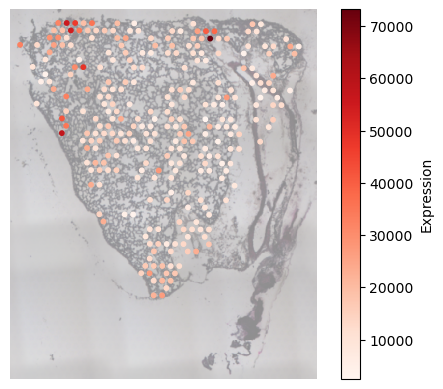

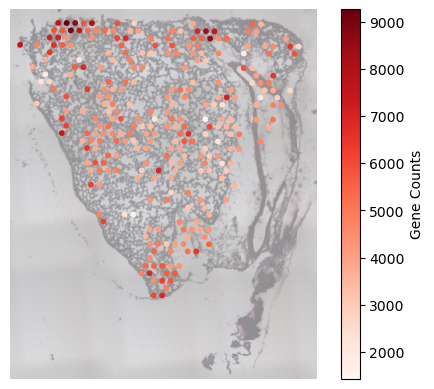

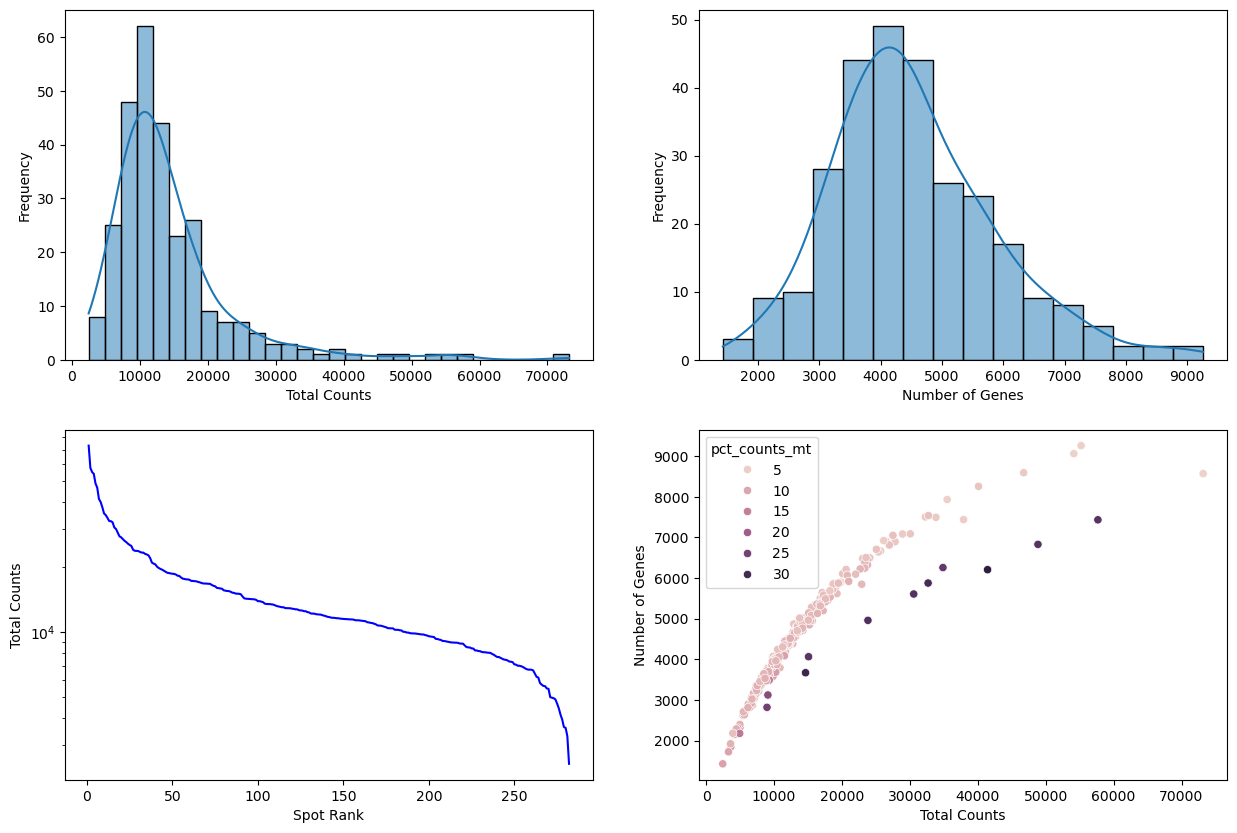

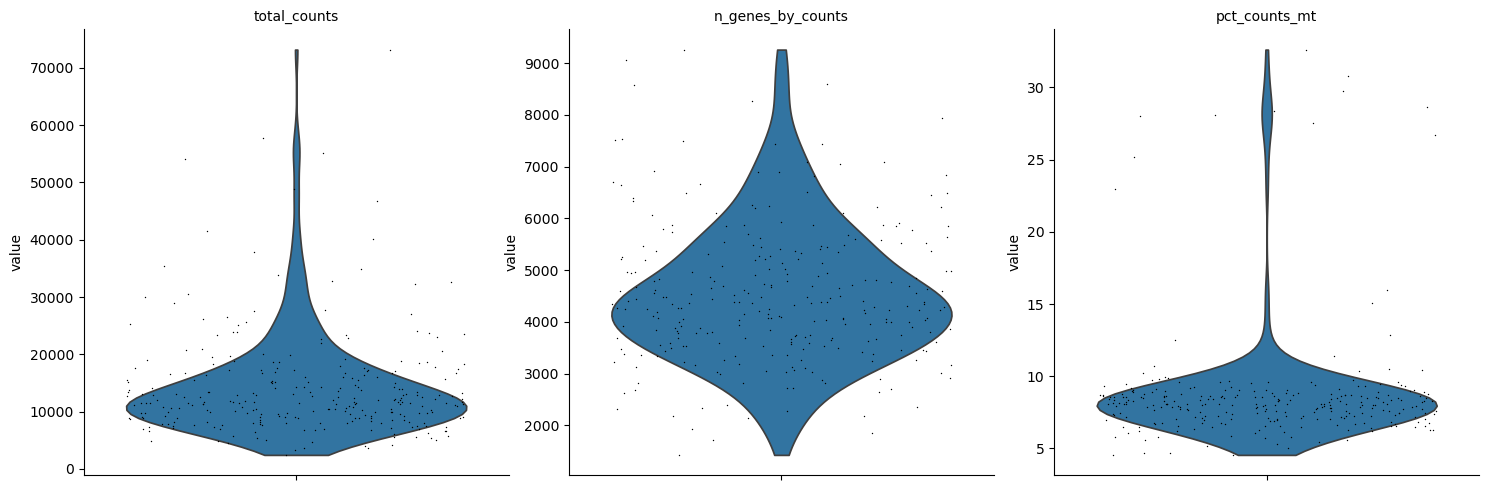

In [56]:
macrophage_M63 = preprocessing(macrophage_M63)

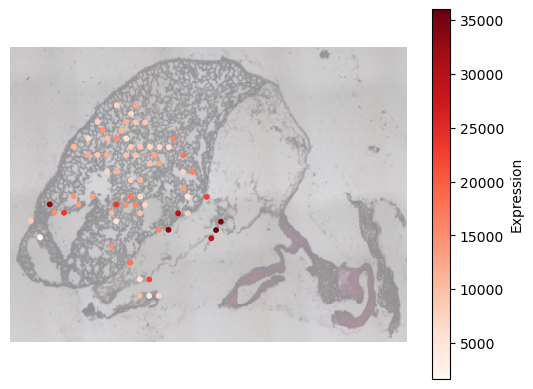

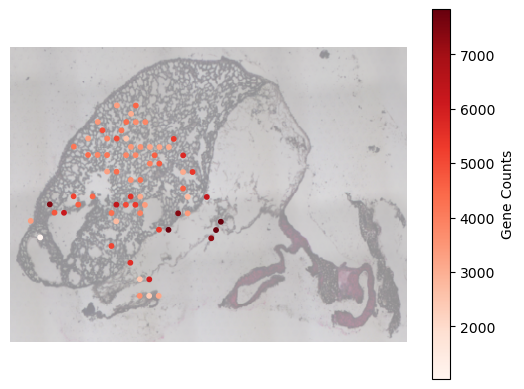

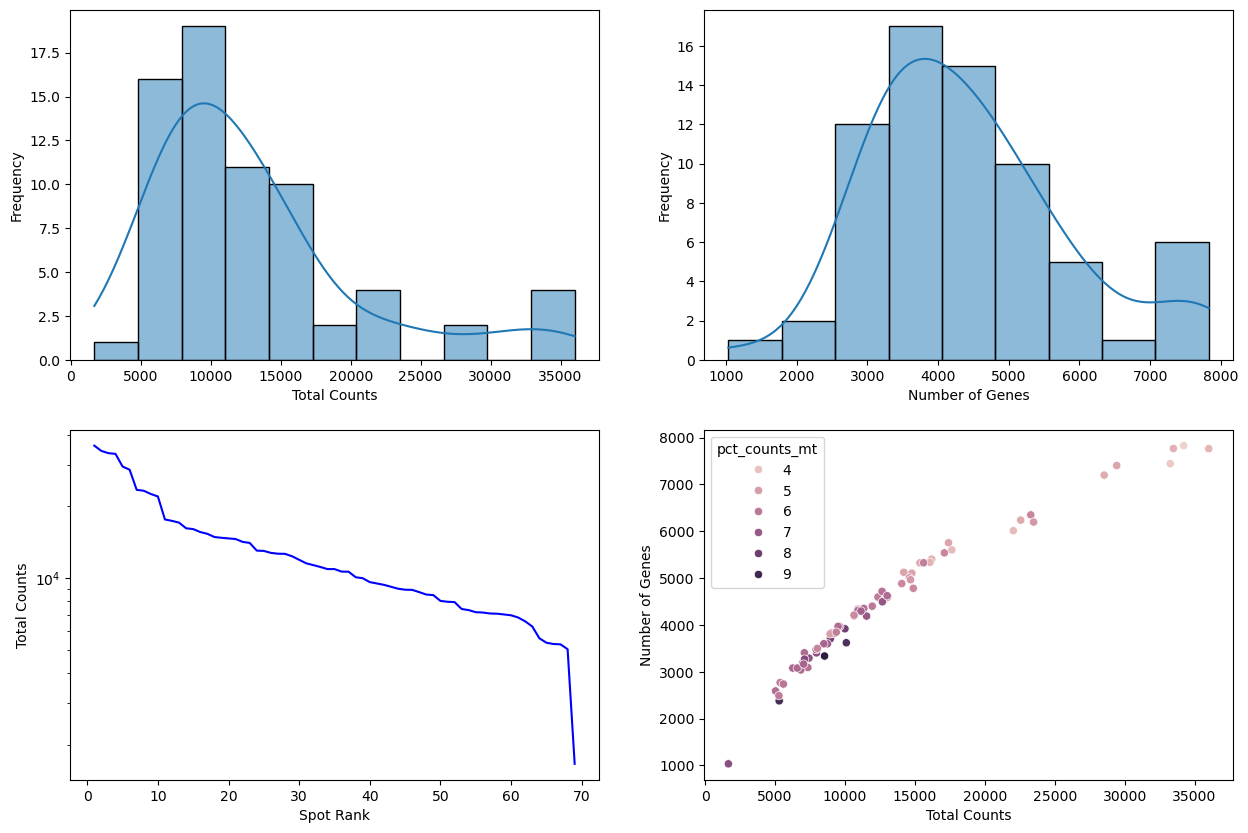

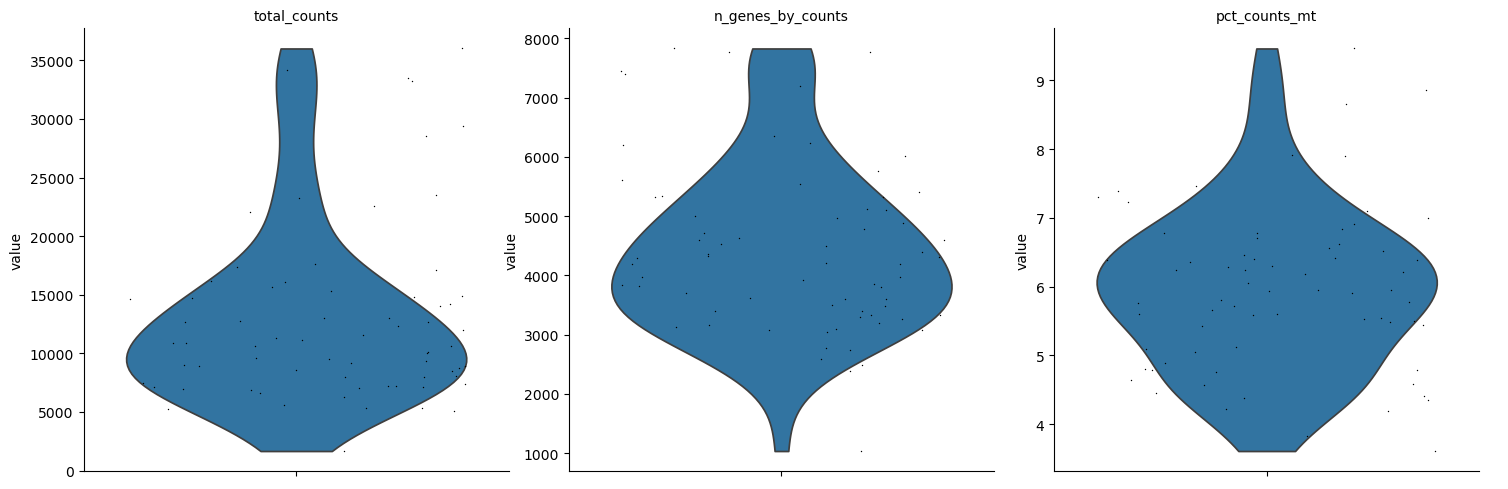

In [57]:
macrophage_F62 = preprocessing(macrophage_F62)

Once the spots that exceed the threshold are removed, all four samples are combined. Each spot is labeled with sample that it belongs to.

The combined data is filtered by genes. Any spot with a number of genes is less than 4 will be removed.

In [58]:
macrophage_M24.obs['lung'] = 'Z_Per'
macrophage_M24.obs['sex'] = 'male'
macrophage_M24.obs['sample'] = '0_Per_1_M24'

macrophage_F31.obs['lung'] = 'Z_Per'
macrophage_F31.obs['sex'] = 'female'
macrophage_F31.obs['sample'] = '0_Per_2_F31'

macrophage_M63.obs['lung'] = 'CTL'
macrophage_M63.obs['sex'] = 'male'
macrophage_M63.obs['sample'] = 'CTL_1_M63'

macrophage_F62.obs['lung'] = 'CTL'
macrophage_F62.obs['sex'] = 'female'
macrophage_F62.obs['sample'] = 'CTL_2_F62'

adata_all = sc.concat([macrophage_M24, macrophage_F31,
                       macrophage_M63, macrophage_F62])
adata_all

/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_58388/1024109031.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage_M24.obs['lung'] = 'Z_Per'
/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_58388/1024109031.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage_F31.obs['lung'] = 'Z_Per'
/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_58388/1024109031.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage_M63.obs['lung'] = 'CTL'
/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_58388/1024109031.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage_F62.obs['lung'] = 'CTL'


AnnData object with n_obs × n_vars = 1249 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'lung', 'sex', 'sample'
    obsm: 'spatial'

In [59]:
sc.pp.filter_genes(adata_all, min_cells = 4)
adata_all

AnnData object with n_obs × n_vars = 1249 × 16448
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'lung', 'sex', 'sample'
    var: 'n_cells'
    obsm: 'spatial'

Next, Normalization

In [60]:
def normalization (adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata

    sc.pp.highly_variable_genes(adata, n_top_genes=3000, inplace=True,
                                layer = 'counts', flavor = 'seurat_v3')

In [61]:
normalization(adata_all)

In [62]:
# Add the lungs picture for easier plotting
adata_all.uns['extent_M24'] = [1800, 5220, 1900, 6600]
adata_all.uns['lung_image_M24'] = root_dir + 'lungs_images/M24.png'

adata_all.uns['extent_F31'] = [1000, 5900, 1100, 6400]
adata_all.uns['lung_image_F31'] = root_dir + 'lungs_images/F31.png'

adata_all.uns['extent_M63'] = [2250, 5400, 2700, 6500]
adata_all.uns['lung_image_M63'] = root_dir + 'lungs_images/M63.png'

adata_all.uns['extent_F62'] = [2670, 6300, 2900, 5600]
adata_all.uns['lung_image_F62'] = root_dir + 'lungs_images/F62.png'

In [63]:
adata_all.write_h5ad(root_dir + 'results/adata_all.h5ad')
# adata_all = ad.read_h5ad(root_dir + 'results/adata_all.h5ad')

## Clustering Analysis

In [64]:
import scvi

In [71]:
def clustering_DE (adata):
    scvi.model.SCVI.setup_anndata(adata, layer = 'counts',
                                  continuous_covariate_keys=['pct_counts_mt', 'total_counts'])
    model_ = scvi.model.SCVI(adata)
    # If GPU is available, consider using accelerator='gpu' for train()
    model_.train()
    model_.save(root_dir + '/results/adata_all_model')

    adata.obsm['X_scVI'] = model_.get_latent_representation()
    adata.layers['scvi_normalized'] = model_.get_normalized_expression(library_size = 1e4)

    sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_scVI')
    sc.tl.leiden(adata, key_added='clusters', resolution=0.5)
    sc.tl.umap(adata)

    adata.uns['cluster_markers'] = model_.differential_expression(groupby='clusters')

In [73]:
clustering_DE(adata_all)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 400/400: 100%|██████████| 400/400 [05:48<00:00,  1.18it/s, v_num=1, train_loss_step=1.04e+4, train_loss_epoch=1.02e+4]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 1/400:   0%|          | 0/400 [17:43<?, ?it/s]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_58388/3014161493.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added='clusters', resolution=0.5)


DE...: 100%|██████████| 8/8 [00:23<00:00,  2.89s/it]


In [77]:
# adata_all.write_h5ad(root_dir + 'results/adata_all.h5ad')
adata_all = ad.read_h5ad(root_dir + 'results/adata_all_UW.h5ad')
adata_all

AnnData object with n_obs × n_vars = 1249 × 16448
    obs: 'lung', 'sex', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'clusters', '_scvi_raw_norm_scaling', 'rel_cell_type'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cluster_markers', 'hvg', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs', 'spatial'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [80]:
adata_all.uns['extent_M24'] = [1800, 5220, 1900, 6600]
adata_all.uns['lung_image_M24'] = root_dir + 'lungs_images/M24.png'

adata_all.uns['extent_F31'] = [1000, 5900, 1100, 6400]
adata_all.uns['lung_image_F31'] = root_dir + 'lungs_images/F31.png'

adata_all.uns['extent_M63'] = [2250, 5400, 2700, 6500]
adata_all.uns['lung_image_M63'] = root_dir + 'lungs_images/M63.png'

adata_all.uns['extent_F62'] = [2670, 6300, 2900, 5600]
adata_all.uns['lung_image_F62'] = root_dir + 'lungs_images/F62.png'

adata_all.write_h5ad(root_dir + 'results/adata_all_UW.h5ad')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


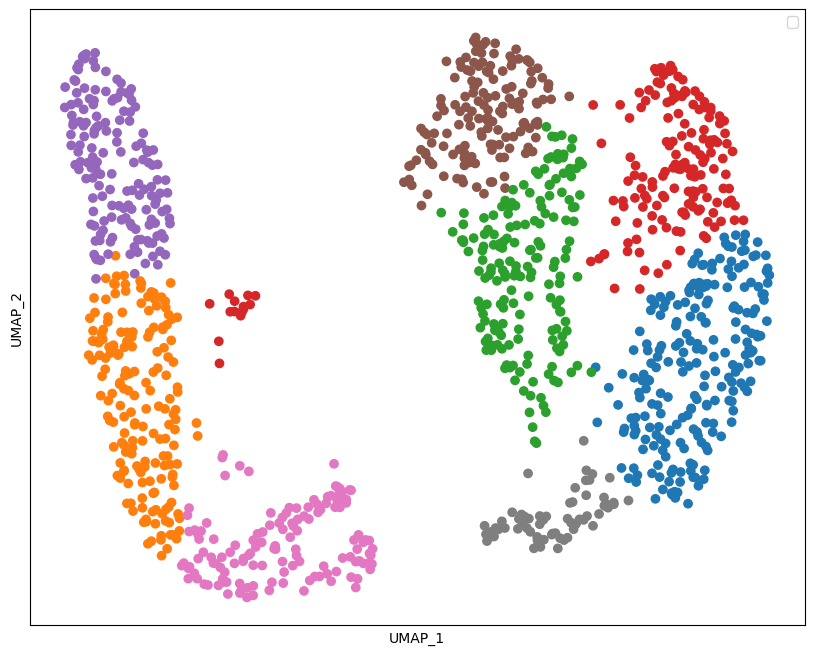

In [81]:
plot_st.plt_umap(adata_all, 'clusters')

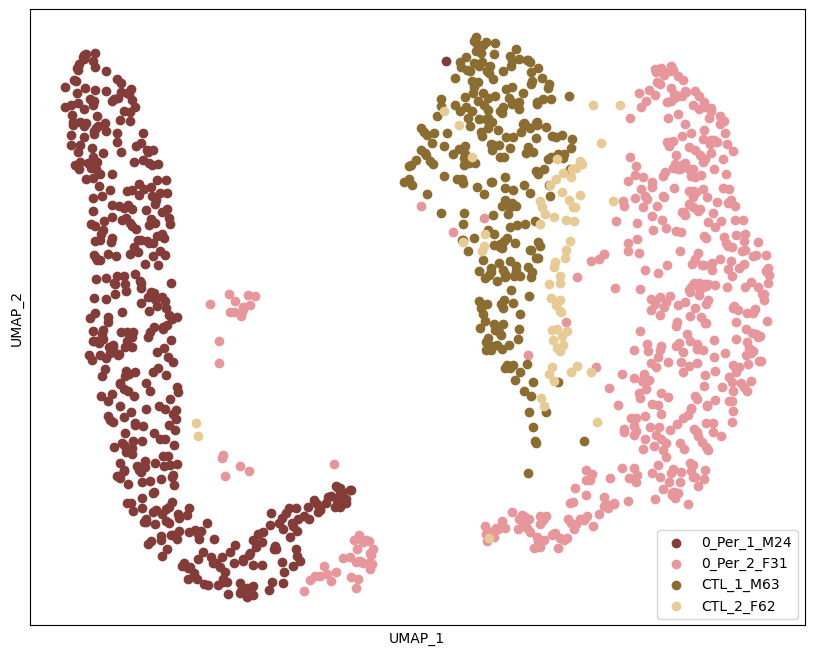

In [82]:
plot_st.plt_umap_sample(adata_all)